# Reuters Multiclass Classification
From Deep Learning with Python, Chapter 3

The Reuters dataset is a set of newswire stories and their topics published by Reuters in 1986. It consists of 8982 training stories and 2246 testing stories. There are 46 different topics which are unevenly distributed although each topic has at least 10 samples in the training set.

_(How does this relate to the Reuters-21578 test set - [UCI Link](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection)?)_

This is an example of a single-label, multiclass classification problem.

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


In [2]:
print("{} training samples".format(len(train_data)))
print("{} testing samples".format(len(test_data)))
print(train_data[10])

8982 training samples
2246 testing samples
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [3]:
print("training data:", train_data.ndim, train_data.shape, train_data.dtype)
print("training labels:", train_labels.ndim, train_labels.shape, train_labels.dtype)

training data: 1 (8982,) object
training labels: 1 (8982,) int64


In [4]:
# Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])
decoded_newswire = [reverse_word_index.get(i-3, "?") for i in train_data[0]]
print(" ".join(decoded_newswire))

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


## Vectorize the Data
As before, convert the sequences of integers into one-hot encoded vectors i.e. 10K vectors with the indexes corresponding to the integer value of the words set to 1.

The labels are also one-hot encoded -- also known as categorical encoded. This could be done using vectorize_sequences() but Keras has a utility that does it automatically.

In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [6]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [7]:
print("x_train:", x_train.ndim, x_train.shape, x_train.dtype)
print("y_train:", one_hot_train_labels.ndim, one_hot_train_labels.shape, one_hot_train_labels.dtype)

x_train: 2 (8982, 10000) float64
y_train: 2 (8982, 46) float32


## Build the Model
This is similar to the previous model but we increase the number of units in each hidden layer because there are 46 possible outputs. The last layer uses a "softmax" activation function which will cause it to output a probability distribution over the 46 possible output classes. The best loss function to usein this case is categorical_crossentropy which measures the distance between two probability distributions.

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Validating Your Approach
In order to monitor the accuracy of the model during training, we create a validation set by taking 1K samples from the original data. This allows us to check the model's accuracy against data that it has not been traing on.

In [9]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## Training Your Model
The call to ```model.fit()``` returns a ```History``` object which contains a ```history``` member which contains data about everything that happened during training.

In [10]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 255us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 110us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 113us/step - loss: 1.0953 - acc: 0.7650 - val_loss: 1.1714 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 113us/step - loss: 0.8699 - acc: 0.8158 - val_loss: 1.0807 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 112us/step - loss: 0.7036 - acc: 0.8475 - val_loss: 0.9846 - val_acc: 0.7820
Epoch 6/20
7982/7982 [==============================] - 1s 112us/step - loss: 0.5671 - acc: 0.8801 - val_loss: 0.9414 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 113us/step - loss: 0.4586 - acc: 0.9050 - val_loss: 0.9091 - val_acc: 0.8020


## Plotting the Training and Validation Loss

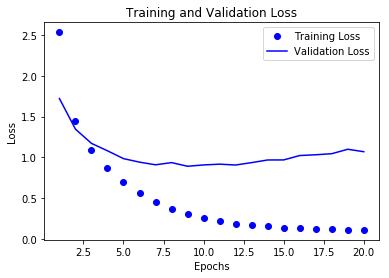

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plotting the Training and Validation Accuracy

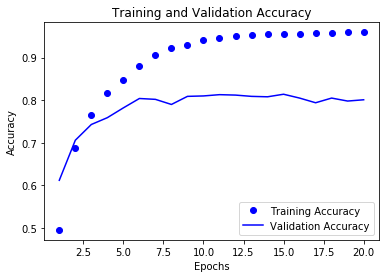

In [13]:
plt.clf()

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Retraining the Model from Scratch

In [14]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 124us/step - loss: 2.5402 - acc: 0.5222 - val_loss: 1.6738 - val_acc: 0.6530
Epoch 2/9
7982/7982 [==============================] - 1s 111us/step - loss: 1.3713 - acc: 0.7127 - val_loss: 1.2764 - val_acc: 0.7180
Epoch 3/9
7982/7982 [==============================] - 1s 113us/step - loss: 1.0141 - acc: 0.7783 - val_loss: 1.1323 - val_acc: 0.7500
Epoch 4/9
7982/7982 [==============================] - 1s 113us/step - loss: 0.7982 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7600
Epoch 5/9
7982/7982 [==============================] - 1s 116us/step - loss: 0.6395 - acc: 0.8627 - val_loss: 0.9752 - val_acc: 0.7940
Epoch 6/9
7982/7982 [==============================] - 1s 114us/step - loss: 0.5122 - acc: 0.8925 - val_loss: 0.9107 - val_acc: 0.8120
Epoch 7/9
7982/7982 [==============================] - 1s 120us/step - loss: 0.4119 - acc: 0.9143 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

In [15]:
print("Results:", results)

Results: [1.0220439414944058, 0.7764915405695499]


This gives an accuracy of ~78%. Compare this to a random classifier:

In [16]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
print("random accuracy:", float(np.sum(hits_array))/len(test_labels))

random accuracy: 0.182546749777382


## Generating Predictions on New Data

In [17]:
predictions = model.predict(x_test)
print("predictions:", predictions.ndim, predictions.shape, predictions.dtype)

predictions: 2 (2246, 46) float32


In [18]:
# verify that the probabilities in a prediction sum to 1
print(np.sum(predictions[0]))

0.99999994


In [19]:
print(predictions[0])

[1.0642886e-05 8.1068370e-05 2.5746222e-05 9.7177839e-01 1.7057892e-02
 1.1642452e-07 8.8585773e-05 3.1081974e-05 3.2074451e-03 2.1114970e-06
 3.0945062e-05 1.5532039e-03 5.0456270e-05 2.6648800e-05 4.3824434e-06
 1.8163822e-05 9.3397498e-04 1.9112643e-04 2.8083156e-04 1.1390189e-03
 7.5731735e-04 4.4485461e-04 7.0230226e-06 5.1655512e-05 1.2498930e-05
 3.0360903e-04 2.5147256e-06 2.6472377e-05 8.1189501e-06 9.8914716e-05
 3.4696018e-04 1.9335317e-04 1.1334881e-05 3.9051505e-05 3.7262886e-05
 2.0709464e-05 1.5663520e-04 4.6035559e-05 9.4092902e-05 2.8505389e-04
 3.3509088e-05 4.6048863e-04 1.8435343e-06 3.3028991e-05 6.4102082e-06
 9.3290037e-06]


In [20]:
# Find the class with the highest probability
print(np.argmax(predictions[0]))

3


### A Diferent Way to Handle Labels and Loss
An alternative way to encode the labels would be to convert them into an integer tensor:

        y_train = np.array(train_labels)
        y_test = np.array(test_labels)

In this case, you would need to change your loss function to "sparse_categorical_crossentropy"

        model.compile(optimizer='rmsprop',
                      loss='sparse_categorical_crossentropy',
                      metrics='['acc'])


## Further Experiments

### 1. Try using 32-unit hidden layers

In [21]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu',input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
print("Results:", results)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 101us/step - loss: 3.0420 - acc: 0.4959 - val_loss: 2.3143 - val_acc: 0.5780
Epoch 2/9
7982/7982 [==============================] - 1s 84us/step - loss: 1.9050 - acc: 0.6254 - val_loss: 1.6516 - val_acc: 0.6490
Epoch 3/9
7982/7982 [==============================] - 1s 82us/step - loss: 1.4018 - acc: 0.7013 - val_loss: 1.3732 - val_acc: 0.7000
Epoch 4/9
7982/7982 [==============================] - 1s 81us/step - loss: 1.1370 - acc: 0.7534 - val_loss: 1.2102 - val_acc: 0.7290
Epoch 5/9
7982/7982 [==============================] - 1s 83us/step - loss: 0.9591 - acc: 0.7937 - val_loss: 1.1103 - val_acc: 0.7510
Epoch 6/9
7982/7982 [==============================] - 1s 83us/step - loss: 0.8200 - acc: 0.8256 - val_loss: 1.0520 - val_acc: 0.7630
Epoch 7/9
7982/7982 [==============================] - 1s 84us/step - loss: 0.7067 - acc: 0.8460 - val_loss: 0.9879 - val_acc: 0.7810
Epoch 8/9
798

### 2. Try using 128 unit hidden layers

In [22]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu',input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
print("Results:", results)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 180us/step - loss: 2.2403 - acc: 0.5251 - val_loss: 1.3922 - val_acc: 0.6810
Epoch 2/9
7982/7982 [==============================] - 1s 154us/step - loss: 1.1567 - acc: 0.7489 - val_loss: 1.1159 - val_acc: 0.7630
Epoch 3/9
7982/7982 [==============================] - 1s 155us/step - loss: 0.8098 - acc: 0.8266 - val_loss: 1.0090 - val_acc: 0.7790
Epoch 4/9
7982/7982 [==============================] - 1s 155us/step - loss: 0.5934 - acc: 0.8773 - val_loss: 0.9372 - val_acc: 0.7950
Epoch 5/9
7982/7982 [==============================] - 1s 156us/step - loss: 0.4287 - acc: 0.9112 - val_loss: 0.8927 - val_acc: 0.8150
Epoch 6/9
7982/7982 [==============================] - 1s 155us/step - loss: 0.3246 - acc: 0.9330 - val_loss: 0.8799 - val_acc: 0.8240
Epoch 7/9
7982/7982 [==============================] - 1s 158us/step - loss: 0.2539 - acc: 0.9445 - val_loss: 0.9215 - val_acc: 0.8080
Epoch 8

### 3. Try using 1 hidden layer

In [23]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu',input_shape=(10000,)))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
print("Results:", results)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 131us/step - loss: 2.5599 - acc: 0.5796 - val_loss: 1.7985 - val_acc: 0.6620
Epoch 2/9
7982/7982 [==============================] - 1s 110us/step - loss: 1.4454 - acc: 0.7214 - val_loss: 1.3311 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 108us/step - loss: 1.0492 - acc: 0.7858 - val_loss: 1.1277 - val_acc: 0.7670
Epoch 4/9
7982/7982 [==============================] - 1s 108us/step - loss: 0.8210 - acc: 0.8326 - val_loss: 1.0177 - val_acc: 0.7880
Epoch 5/9
7982/7982 [==============================] - 1s 108us/step - loss: 0.6604 - acc: 0.8682 - val_loss: 0.9411 - val_acc: 0.8030
Epoch 6/9
7982/7982 [==============================] - 1s 112us/step - loss: 0.5399 - acc: 0.8914 - val_loss: 0.8971 - val_acc: 0.8100
Epoch 7/9
7982/7982 [==============================] - 1s 112us/step - loss: 0.4436 - acc: 0.9090 - val_loss: 0.8529 - val_acc: 0.8210
Epoch 8

### 4 Try using 3 hidden layers

In [24]:
model4 = models.Sequential()
model4.add(layers.Dense(64, activation='relu',input_shape=(10000,)))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(46, activation='softmax'))
model4.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
history4 = model4.fit(partial_x_train,
                     partial_y_train,
                     epochs=9,
                     batch_size=512,
                     validation_data=(x_val, y_val))
results4 = model4.evaluate(x_test, one_hot_test_labels)
print("Results:", results4)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 144us/step - loss: 2.5310 - acc: 0.4595 - val_loss: 1.6654 - val_acc: 0.6060
Epoch 2/9
7982/7982 [==============================] - 1s 112us/step - loss: 1.4217 - acc: 0.6835 - val_loss: 1.3320 - val_acc: 0.7070
Epoch 3/9
7982/7982 [==============================] - 1s 113us/step - loss: 1.0833 - acc: 0.7616 - val_loss: 1.1771 - val_acc: 0.7480
Epoch 4/9
7982/7982 [==============================] - 1s 112us/step - loss: 0.8613 - acc: 0.8141 - val_loss: 1.0723 - val_acc: 0.7830
Epoch 5/9
7982/7982 [==============================] - 1s 113us/step - loss: 0.6939 - acc: 0.8438 - val_loss: 1.0052 - val_acc: 0.7890
Epoch 6/9
7982/7982 [==============================] - 1s 113us/step - loss: 0.5612 - acc: 0.8732 - val_loss: 0.9920 - val_acc: 0.7930
Epoch 7/9
7982/7982 [==============================] - 1s 113us/step - loss: 0.4548 - acc: 0.9009 - val_loss: 0.9936 - val_acc: 0.7870
Epoch 8